In [ ]:
# Install Simpy
try:
    import simpy  # Try importing SimPy
except ImportError:
    print("SimPy is not installed. Installing SimPy...")
    # Install SimPy if it's not installed
    !pip install simpy

SimPy is not installed. Installing SimPy...


In [ ]:
import simpy  # importing SimPy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


Running 100 simulations to average
Average wait time: 1.09 hours
Average number of customers in system: 7.58
Average server utilization: 0.79
Maximum number of customers in system: 55
Plotting average wait time distribution...


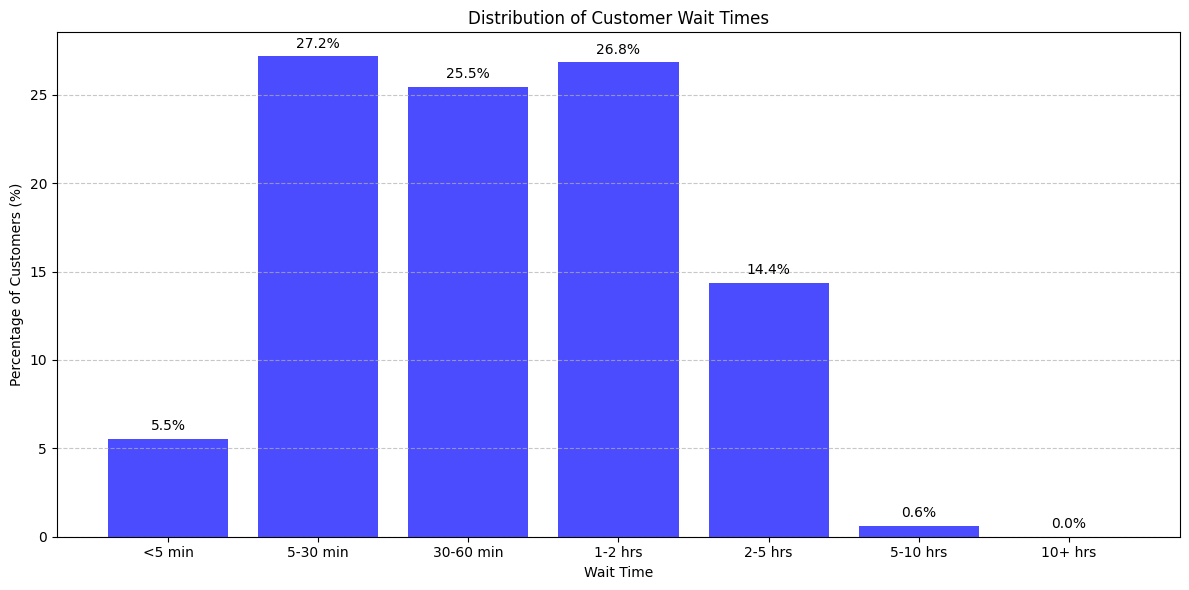

In [ ]:
class QueueSimulation2:
    def __init__(self, initial_lambda_rate, mu_rate, duration, num_servers):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.mu_rate = mu_rate
        self.duration = duration
        self.num_servers = num_servers # number of servers
        self.lambda_history = [(0, initial_lambda_rate)] # Track lambda changes over time

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update lambda rate every hour
    def update_lambda(self, env):
        while True:
            # Wait for 1 hour
            yield env.timeout(1)

            # Randomly change lambda to an integer between 2 and 12
            self.lambda_rate = random.randint(2, 12)

            # Record the new lambda rate and time
            self.lambda_history.append((env.now, self.lambda_rate))

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0 # Track total time servers busy
        while True:
            yield env.timeout(self.generate_interarrival()) # Yield until the next arrival, based on the interarrival time
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # When the customer arrives, start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            queue_length = len(servers.queue)
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users))) # Track the number of customers currently in the system

            # Calculate current total wait time in the system
            current_wait_time = sum(env.now - arrival_time for arrival_time in self.active_customers)
            self.wait_times_over_time.append((t_arrival, current_wait_time))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Yield until the customer gets service (i.e., waits for a server to be available)
            yield request

            # Generate and wait for the service time (time spent being served)
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time # Update time servers were busy
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1)) # Track the number of customers in the system after this customer departs

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate current total wait time in the system after departure
            current_wait_time = sum(env.now - arrival_time for arrival_time in self.active_customers)
            self.wait_times_over_time.append((t_depart, current_wait_time))

            # Log how much servers were utilised
            self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart)))

            # Record the wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time) # Calculate the wait time (departure time - arrival time)
            self.service_t.append(service_time) # Record the service time
            self.log.append((customer, t_arrival, t_service, t_depart)) # Store the details for the customer

    # Method to run the simulation
    def run_simulation(self):
        # Initialise lists to store results for wait times, service times, and system state
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)] # Track utilisation over time
        self.log = []
        self.active_customers = [] # Track active customers by their arrival time
        self.wait_times_over_time = [(0, 0)] # Track total wait time over time
        self.max_customers = 0 # Maximum customers in system at one time

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)  #Set the number of servers

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate maximum customers in system
        max_customers = max(num for _, num in self.in_systems)

        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0 #calculate the average number of customers

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, max_customers, wait_time_dist

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run a single simulation and return wait time distribution
def run_single_simulation(initial_lambda_rate, mu_rate, duration, num_servers):
    sim = QueueSimulation2(initial_lambda_rate, mu_rate, duration, num_servers)
    _, _, _, _, _, wait_time_dist = sim.run_simulation()
    return wait_time_dist

def run_multiple_simulations(num_runs, initial_lambda_rate, mu_rate, duration, num_servers):
    wait_times, num_customers, utilisations, max_customers_list, wait_time_distributions = [], [], [], [], []

    for _ in range(num_runs):
        avg_service, avg_wait, avg_num_customers, avg_util, max_customers, wait_time_dist = QueueSimulation2(initial_lambda_rate, mu_rate, duration, num_servers).run_simulation()
        wait_times.append(avg_wait)
        num_customers.append(avg_num_customers)
        utilisations.append(avg_util)
        max_customers_list.append(max_customers)
        wait_time_distributions.append(wait_time_dist)

    avg_distribution = np.mean(wait_time_distributions, axis=0)
    return np.mean(wait_times), np.mean(num_customers), np.mean(utilisations), np.max(max_customers_list), avg_distribution

# Function to plot wait time distribution
def plot_wait_time_distribution(distribution):
    categories = ['<5 min', '5-30 min', '30-60 min', '1-2 hrs', '2-5 hrs', '5-10 hrs', '10+ hrs']

    plt.figure(figsize=(12, 6))
    plt.bar(categories, distribution, color='blue', alpha=0.7)
    plt.title('Distribution of Customer Wait Times')
    plt.xlabel('Wait Time')
    plt.ylabel('Percentage of Customers (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on top of bars
    for i, v in enumerate(distribution):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

# Main function to run simulations and plot results
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 8  # Initial arrival rate (customers per hour)
    service_time = 0.5
    mu_rate = 1/service_time  # Service rate per hour
    duration = 24  # Simulation duration in hours
    num_servers = 4  # Number of servers
    num_runs = 100  # Number of simulations to run

    ' Following commented out part is there to run and plot a single run'
    ' Not used in the report but is worth keeping if needed'
    # # Run a single simulation to show detailed results
    # print("Running a single detailed simulation...")
    # sim = QueueSimulation2(initial_lambda_rate, mu_rate, duration, num_servers)
    # avg_service, avg_wait, avg_customers, avg_util, max_customers, wait_time_dist = sim.run_simulation()

    # # Print results
    # print(f"Average service time: {avg_service:.2f} hours")
    # print(f"Average wait time: {avg_wait:.2f} hours")
    # print(f"Average number of customers in system: {avg_customers:.2f}")
    # print(f"Average server utilization: {avg_util:.2f}")
    # print(f"Maximum customers in system at one time: {max_customers:.2f}")

    # # Plot wait time distribution for single simulation
    # print("Plotting wait time distribution for single simulation...")
    # plot_wait_time_distribution(wait_time_dist)

    # # Plot system wait time for single simulation
    # times, wait_times = zip(*wait_times_over_time)

    # plt.figure(figsize=(12, 6))
    # plt.plot(times, wait_times)
    # plt.title('Total System Wait Time Over Time')
    # plt.xlabel('Time (hours)')
    # plt.ylabel('Total Wait Time (hours)')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    ' End of commented out part for a single run '

    # Run multiple simulations and get average distribution
    print(f"\nRunning {num_runs} simulations to average")

    avg_wait, avg_customers, avg_util, max_customers, avg_distribution = run_multiple_simulations(num_runs, initial_lambda_rate, mu_rate, duration, num_servers)

    print(f"Average wait time: {avg_wait:.2f} hours")
    print(f"Average number of customers in system: {avg_customers:.2f}")
    print(f"Average server utilization: {avg_util:.2f}")
    print(f"Maximum number of customers in system: {max_customers}")


    # Plot average wait time distribution
    print("Plotting average wait time distribution...")
    plot_wait_time_distribution(avg_distribution)


Running 1000 simulations for Base Case...
Scenario: Base Case
  Number of servers: 4
  Service time: 0.50 hours
  Average wait time: 1.10 hours
  Average number of customers in system: 7.62
  Average server utilization: 0.78
  Maximum number of customers in system: 78

Running 1000 simulations for Increasing servers by a third...
Scenario: Increasing servers by a third
  Number of servers: 6
  Service time: 0.50 hours
  Average wait time: 0.56 hours
  Average number of customers in system: 3.77
  Average server utilization: 0.53
  Maximum number of customers in system: 35

Running 1000 simulations for Reducing Service Time by a third...
Scenario: Reducing Service Time by a third
  Number of servers: 4
  Service time: 0.33 hours
  Average wait time: 0.42 hours
  Average number of customers in system: 2.85
  Average server utilization: 0.54
  Maximum number of customers in system: 30

Plotting wait time distributions for all scenarios...


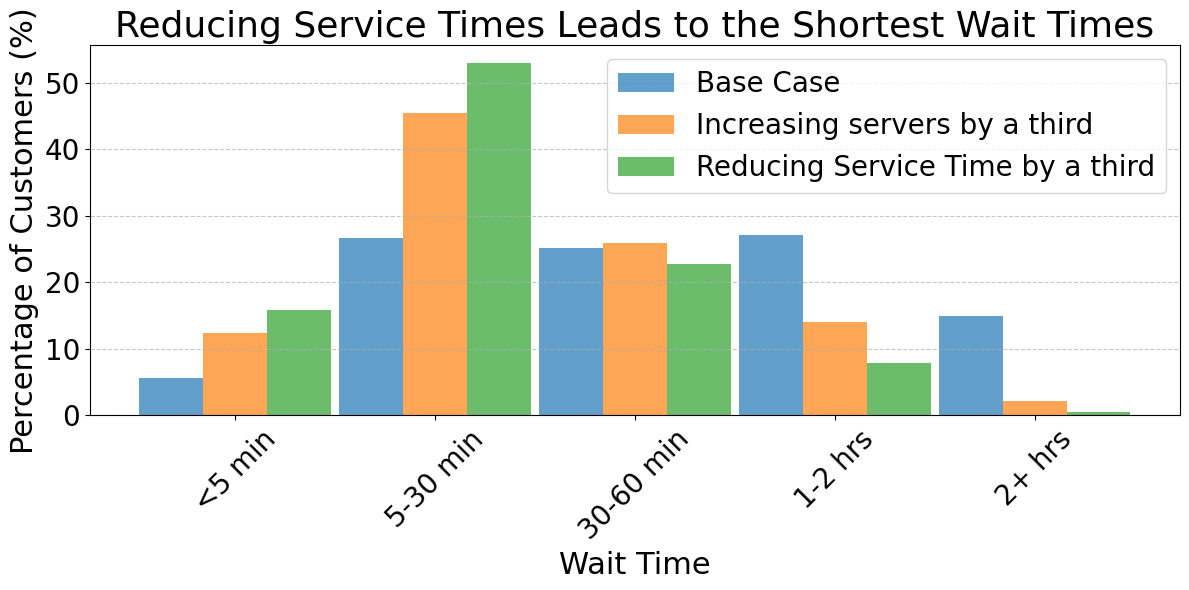


Summary Comparison:
Scenario                | Avg Wait (hrs) | Avg Customers | Avg Utilization | Max Customers
------------------------|----------------|---------------|-----------------|-------------
Base Case                | 1.10           | 7.62          | 0.78            | 78
Increasing servers by a third | 0.56           | 3.77          | 0.53            | 35
Reducing Service Time by a third | 0.42           | 2.85          | 0.54            | 30


In [ ]:
# Modified function to plot multiple wait time distributions on the same graph
def plot_multiple_wait_time_distributions(distributions, labels):
    categories = ['<5 min', '5-30 min', '30-60 min', '1-2 hrs', '2+ hrs']

    # Find which categories have non-zero values in any distribution
    non_zero_indices = []
    for i in range(len(categories)):
        if any(dist[i] > 0 for dist in distributions):
            non_zero_indices.append(i)

    # Filter categories and distributions to only include non-zero bins
    filtered_categories = [categories[i] for i in non_zero_indices]
    filtered_distributions = [[dist[i] for i in non_zero_indices] for dist in distributions]

    plt.figure(figsize=(12, 6))

    bar_width = 0.32
    positions = np.arange(len(filtered_categories))

    for i, (distribution, label) in enumerate(zip(filtered_distributions, labels)):
        plt.bar(positions + i*bar_width, distribution, width=bar_width, alpha=0.7, label=label)

    plt.title('Reducing Service Times Leads to the Shortest Wait Times', size=26)
    plt.xlabel('Wait Time', size=22)
    plt.ylabel('Percentage of Customers (%)', size=22)
    plt.xticks(positions + bar_width, filtered_categories, rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=20)

    plt.tight_layout()
    plt.show()

# Main function to run simulations and plot results
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 8  # Initial arrival rate (customers per hour)
    service_time_base = 0.5
    mu_rate_base = 1/service_time_base  # Service rate per hour
    duration = 24  # Simulation duration in hours
    num_servers_base = 4  # Number of servers
    num_runs = 1000  # Number of simulations to run

    # Define scenarios
    scenarios = [
        {"name": "Base Case", "servers": num_servers_base, "mu_rate": mu_rate_base},
        {"name": rf"Increasing servers by a third", "servers": num_servers_base + 2, "mu_rate": mu_rate_base},
        {"name": rf"Reducing Service Time by a third", "servers": num_servers_base, "mu_rate": 1/(service_time_base*2/3)}
    ]

    # Run all scenarios
    results = []
    distributions = []
    labels = []

    for scenario in scenarios:
        print(f"\nRunning {num_runs} simulations for {scenario['name']}...")

        avg_wait, avg_customers, avg_util, max_customers, avg_distribution = run_multiple_simulations(
            num_runs, initial_lambda_rate, scenario['mu_rate'], duration, scenario['servers']
        )

        results.append({
            "name": scenario['name'],
            "avg_wait": avg_wait,
            "avg_customers": avg_customers,
            "avg_util": avg_util,
            "max_customers": max_customers
        })

        distributions.append(avg_distribution)
        labels.append(scenario['name'])

        print(f"Scenario: {scenario['name']}")
        print(f"  Number of servers: {scenario['servers']}")
        print(f"  Service time: {1/scenario['mu_rate']:.2f} hours")
        print(f"  Average wait time: {avg_wait:.2f} hours")
        print(f"  Average number of customers in system: {avg_customers:.2f}")
        print(f"  Average server utilization: {avg_util:.2f}")
        print(f"  Maximum number of customers in system: {max_customers}")

    # Plot all distributions on the same graph
    print("\nPlotting wait time distributions for all scenarios...")
    plot_multiple_wait_time_distributions(distributions, labels)

    # Print summary comparison
    print("\nSummary Comparison:")
    print("Scenario                | Avg Wait (hrs) | Avg Customers | Avg Utilization | Max Customers")
    print("------------------------|----------------|---------------|-----------------|-------------")
    for r in results:
        print(f"{r['name']:<24} | {r['avg_wait']:<14.2f} | {r['avg_customers']:<13.2f} | {r['avg_util']:<15.2f} | {r['max_customers']}")

Comparing simulations with and without lunch rush...
Running simulation without lunch rush...
Running simulation with lunch rush...


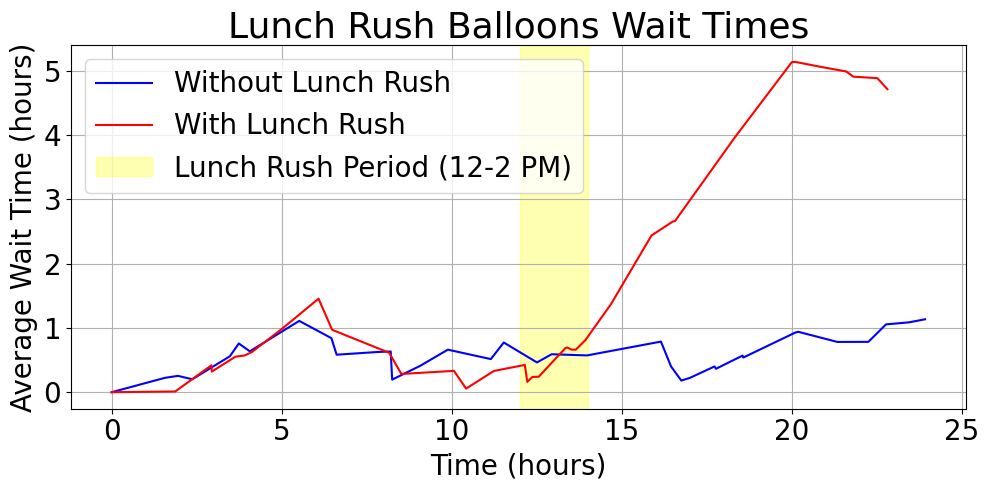

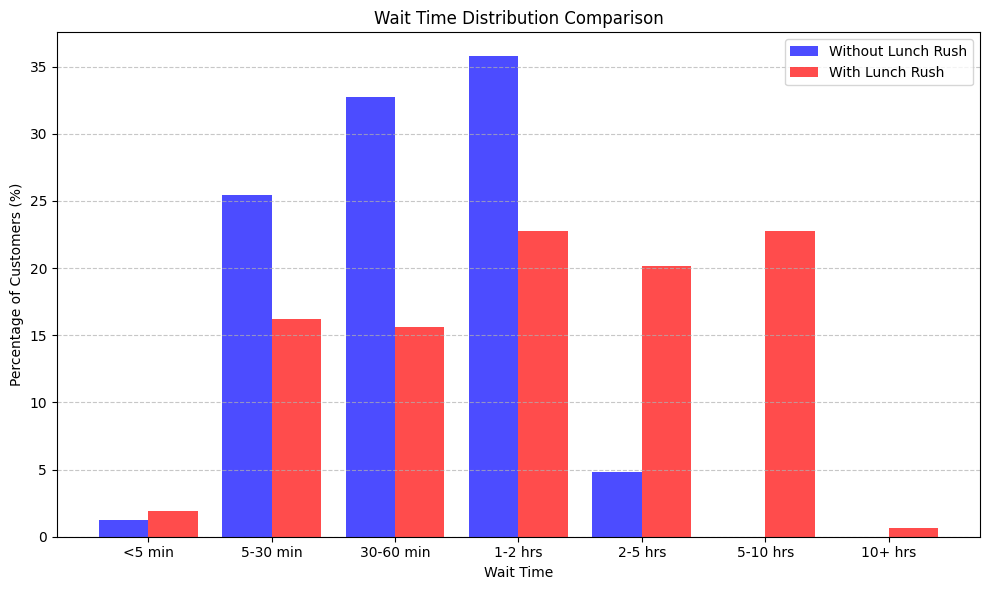


Statistics Without Lunch Rush:
Average service time: 0.54 hours
Average wait time: 1.01 hours
Average number of customers in system: 7.62
Average server utilization: 0.92

Statistics With Lunch Rush:
Average service time: 0.54 hours
Average wait time: 2.92 hours
Average number of customers in system: 34.08
Average server utilization: 0.87

Impact of Lunch Rush:
Wait time increase: 1.91 hours (189.6%)
Average customers increase: 26.46 (347.1%)
Utilization increase: -0.05 (-5.9%)

Generating hourly wait time analysis...
Calculating hourly metrics for normal scenario...
Calculating hourly metrics for lunch rush scenario...


In [ ]:
class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, mu_rate, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.mu_rate = mu_rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to compare simulations with and without lunch rush
def compare_lunch_rush_simulations(initial_lambda_rate, mu_rate, duration, num_servers):
    print("Running simulation without lunch rush...")
    sim_normal = QueueSimulation_lunchRush(initial_lambda_rate, mu_rate, duration, num_servers, lunch_rush=False)
    normal_results = sim_normal.run_simulation()

    print("Running simulation with lunch rush...")
    sim_lunch = QueueSimulation_lunchRush(initial_lambda_rate, mu_rate, duration, num_servers, lunch_rush=True)
    lunch_results = sim_lunch.run_simulation()

    # Extract average wait times data and sort for plotting
    normal_data = sorted(normal_results[5])
    lunch_data = sorted(lunch_results[5])
    normal_times, normal_avg_waits = zip(*normal_data) if normal_data else ([], [])
    lunch_times, lunch_avg_waits = zip(*lunch_data) if lunch_data else ([], [])

    # Create figure for average wait times comparison
    plt.figure(figsize=(10, 5))

    # Plot average wait times
    if normal_times and lunch_times:
        plt.plot(normal_times, normal_avg_waits, label='Without Lunch Rush', color='blue')
        plt.plot(lunch_times, lunch_avg_waits, label='With Lunch Rush', color='red')

        # Highlight lunch rush period
        plt.axvspan(12, 14, color='yellow', alpha=0.3, label='Lunch Rush Period (12-2 PM)')

    plt.title('Lunch Rush Balloons Wait Times', size=26)
    plt.xlabel('Time (hours)', size=20)
    plt.ylabel('Average Wait Time (hours)', size=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

    # Plot histogram of customers average wait time
    fig, ax = plt.subplots(figsize=(10, 6))  # Single axis

    categories = ['<5 min', '5-30 min', '30-60 min', '1-2 hrs', '2-5 hrs', '5-10 hrs', '10+ hrs']
    normal_values = normal_results[7]
    lunch_values = lunch_results[7]

    # Filter out categories where both values are zero
    filtered_categories = []
    filtered_normal_values = []
    filtered_lunch_values = []

    for cat, norm_val, lunch_val in zip(categories, normal_values, lunch_values):
        if norm_val > 0 or lunch_val > 0:  # Keep only non-zero categories
            filtered_categories.append(cat)
            filtered_normal_values.append(norm_val)
            filtered_lunch_values.append(lunch_val)

    # Get new x positions
    x = np.arange(len(filtered_categories))
    width = 0.4  # Bar width

    # Plot both histograms with offset
    ax.bar(x - width/2, filtered_normal_values, width=width, color='blue', alpha=0.7, label='Without Lunch Rush')
    ax.bar(x + width/2, filtered_lunch_values, width=width, color='red', alpha=0.7, label='With Lunch Rush')

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(filtered_categories)
    ax.set_title('Wait Time Distribution Comparison')
    ax.set_xlabel('Wait Time')
    ax.set_ylabel('Percentage of Customers (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()  # Add legend

    plt.tight_layout()
    plt.show()

    # Return key statistics for comparison
    return {
        'normal': {
            'avg_service_time': normal_results[0],
            'avg_wait_time': normal_results[1],
            'avg_customers': normal_results[2],
            'avg_utilization': normal_results[3]
        },
        'lunch_rush': {
            'avg_service_time': lunch_results[0],
            'avg_wait_time': lunch_results[1],
            'avg_customers': lunch_results[2],
            'avg_utilization': lunch_results[3]
        }
    }

# Main function to run simulations and plot results
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    service_time = 0.5
    mu_rate = 1/service_time  # Service rate per hour
    duration = 24  # Simulation duration in hours
    num_servers = 4  # Number of servers

    # Compare simulations with and without lunch rush
    print("Comparing simulations with and without lunch rush...")
    stats = compare_lunch_rush_simulations(initial_lambda_rate, mu_rate, duration, num_servers)

    # Print comparison statistics
    print("\nStatistics Without Lunch Rush:")
    print(f"Average service time: {stats['normal']['avg_service_time']:.2f} hours")
    print(f"Average wait time: {stats['normal']['avg_wait_time']:.2f} hours")
    print(f"Average number of customers in system: {stats['normal']['avg_customers']:.2f}")
    print(f"Average server utilization: {stats['normal']['avg_utilization']:.2f}")

    print("\nStatistics With Lunch Rush:")
    print(f"Average service time: {stats['lunch_rush']['avg_service_time']:.2f} hours")
    print(f"Average wait time: {stats['lunch_rush']['avg_wait_time']:.2f} hours")
    print(f"Average number of customers in system: {stats['lunch_rush']['avg_customers']:.2f}")
    print(f"Average server utilization: {stats['lunch_rush']['avg_utilization']:.2f}")

    print("\nImpact of Lunch Rush:")
    wait_time_increase = (stats['lunch_rush']['avg_wait_time'] - stats['normal']['avg_wait_time'])
    wait_time_percent = (wait_time_increase / stats['normal']['avg_wait_time'] * 100) if stats['normal']['avg_wait_time'] > 0 else 0
    print(f"Wait time increase: {wait_time_increase:.2f} hours ({wait_time_percent:.1f}%)")

    customers_increase = (stats['lunch_rush']['avg_customers'] - stats['normal']['avg_customers'])
    customers_percent = (customers_increase / stats['normal']['avg_customers'] * 100) if stats['normal']['avg_customers'] > 0 else 0
    print(f"Average customers increase: {customers_increase:.2f} ({customers_percent:.1f}%)")

    utilization_increase = (stats['lunch_rush']['avg_utilization'] - stats['normal']['avg_utilization'])
    utilization_percent = (utilization_increase / stats['normal']['avg_utilization'] * 100) if stats['normal']['avg_utilization'] > 0 else 0
    print(f"Utilization increase: {utilization_increase:.2f} ({utilization_percent:.1f}%)")

    # Run a simpler comparison of hourly wait times for clarity
    print("\nGenerating hourly wait time analysis...")

    # Function to get hourly average wait times from a simulation
    def get_hourly_wait_times(lambda_rate, with_lunch_rush):
        sim = QueueSimulation_lunchRush(lambda_rate, mu_rate, duration, num_servers, lunch_rush=with_lunch_rush)
        sim.run_simulation()

        # Get wait times by hour
        hourly_waits = [[] for _ in range(int(duration) + 1)]

        for wait_time in sim.waits:
            # Only for simplicity, we just track if the wait is above threshold
            if wait_time > 0.5:  # wait times over 30 minutes
                hour = int(wait_time) % 24
                hourly_waits[hour].append(wait_time)

        # Calculate average wait times by hour
        hourly_avg_waits = []
        for hour_waits in hourly_waits:
            if hour_waits:
                hourly_avg_waits.append(np.mean(hour_waits))
            else:
                hourly_avg_waits.append(0)

        return hourly_avg_waits

    # Get hourly wait times for both scenarios
    print("Calculating hourly metrics for normal scenario...")
    normal_hourly_waits = get_hourly_wait_times(initial_lambda_rate, False)

    print("Calculating hourly metrics for lunch rush scenario...")
    lunch_hourly_waits = get_hourly_wait_times(initial_lambda_rate, True)



Running simulation with service time = 0.5 hours...

Running simulation with service time = 0.4166666666666667 hours...

Running simulation with service time = 0.3333333333333333 hours...

Running simulation with service time = 0.25 hours...

Running simulation with service time = 0.16666666666666666 hours...

Comparison of Different Service Times with Lunch Rush:
----------------------------------------------------------------------------------------------------
Service Time (hours) Avg Service Time     Avg Wait Time        Avg Customers        Avg Utilization     
----------------------------------------------------------------------------------------------------
0.500                0.532                2.400                16.281               0.860               
0.417                0.407                2.092                15.642               0.757               
0.333                0.355                0.567                4.352                0.676               
0.250     

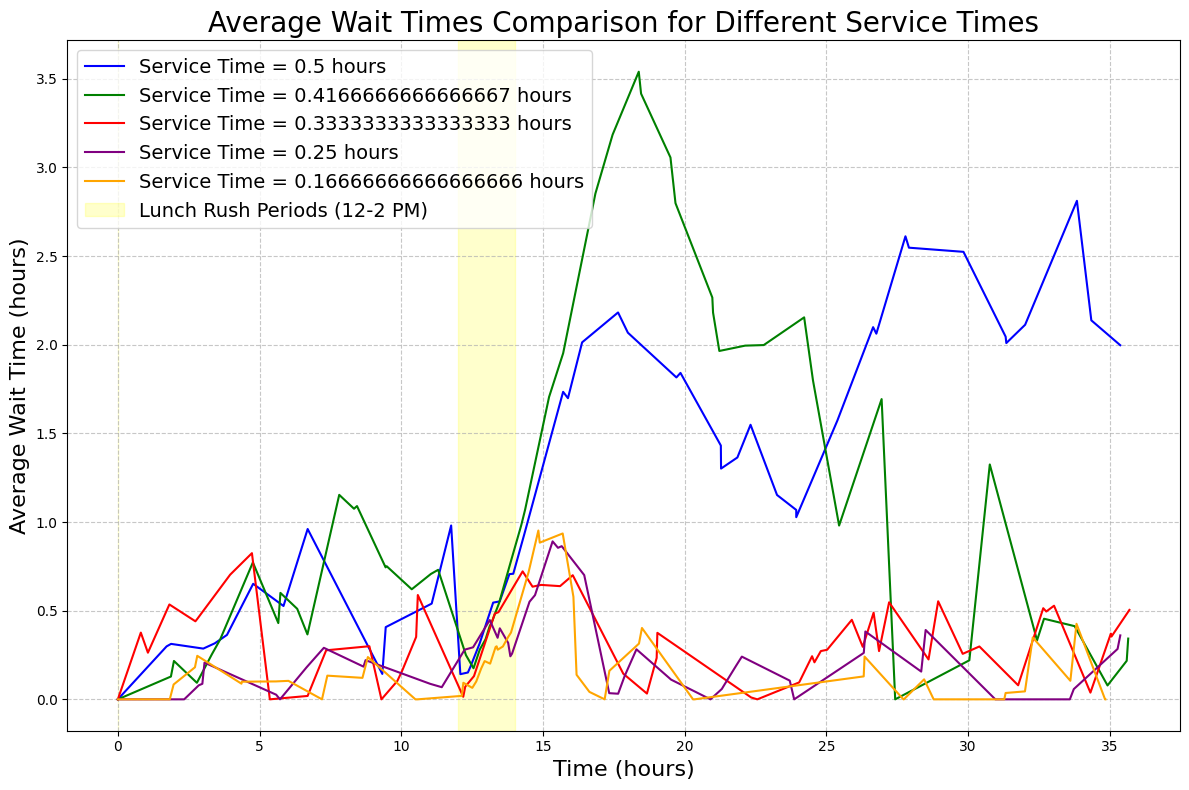

In [ ]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt

class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, mu_rate, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.mu_rate = mu_rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run multiple service time simulations with lunch rush
def run_multiple_service_time_simulations(initial_lambda_rate, service_times, duration, num_servers):
    results = {}

    # Run simulations for each service time
    for service_time in service_times:
        mu_rate = 1/service_time  # Service rate per hour
        print(f"\nRunning simulation with service time = {service_time} hours...")

        # Run simulation with lunch rush
        sim_lunch = QueueSimulation_lunchRush(initial_lambda_rate, mu_rate, duration, num_servers, lunch_rush=True)
        lunch_results = sim_lunch.run_simulation()

        # Store results
        results[service_time] = {
            'avg_service_time': lunch_results[0],
            'avg_wait_time': lunch_results[1],
            'avg_customers': lunch_results[2],
            'avg_utilization': lunch_results[3],
            'wait_times_data': lunch_results[5]  # This contains the time series data for wait times
        }

    return results

# Function to display comparison table
def display_comparison_table(results, service_times):
    # Prepare data for the table
    data = {
        'Service Time (hours)': service_times,
        'Avg Service Time (hours)': [results[st]['avg_service_time'] for st in service_times],
        'Avg Wait Time (hours)': [results[st]['avg_wait_time'] for st in service_times],
        'Avg Customers in System': [results[st]['avg_customers'] for st in service_times],
        'Avg Server Utilization': [results[st]['avg_utilization'] for st in service_times]
    }

    # Print the table
    print("\nComparison of Different Service Times with Lunch Rush:")
    print("-" * 100)
    print(f"{'Service Time (hours)':<20} {'Avg Service Time':<20} {'Avg Wait Time':<20} {'Avg Customers':<20} {'Avg Utilization':<20}")
    print("-" * 100)

    for i, st in enumerate(service_times):
        print(f"{st:<20.3f} {data['Avg Service Time (hours)'][i]:<20.3f} {data['Avg Wait Time (hours)'][i]:<20.3f} {data['Avg Customers in System'][i]:<20.3f} {data['Avg Server Utilization'][i]:<20.3f}")

    print("-" * 100)

    return data

# Function to plot the wait times for different service times
def plot_wait_times_comparison(results, service_times):
    plt.figure(figsize=(12, 8))

    # Colors for different service times
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Plot data for each service time
    for i, st in enumerate(service_times):
        # Extract and sort time series data
        wait_data = sorted(results[st]['wait_times_data'])
        if wait_data:
            times, wait_values = zip(*wait_data)
            plt.plot(times, wait_values, label=f'Service Time = {st} hours', color=colors[i % len(colors)])

    # Highlight lunch rush periods (they repeat every 24 hours)
    for day in range(int(duration/24) + 1):  # For each day in the simulation
        start_hour = day * 24 + 12
        end_hour = day * 24 + 14
        if start_hour < duration:
            end_hour = min(end_hour, duration)  # Make sure we don't go beyond simulation time
            plt.axvspan(start_hour, end_hour, color='yellow', alpha=0.2)

    # Add a single legend entry for lunch rush periods
    plt.axvspan(0, 0, color='yellow', alpha=0.2, label='Lunch Rush Periods (12-2 PM)')

    # Formatting
    plt.title('Average Wait Times Comparison for Different Service Times', fontsize=20)
    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Average Wait Time (hours)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tight_layout()

    # Display the plot
    plt.show()

# Main function to run simulations with multiple service times
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    service_times = [0.5, 5/12, 1/3, 1/4, 1/6]  # Different service times to test
    duration = 36  # Extended simulation duration in hours
    num_servers = 4  # Number of servers

    # Run simulations for different service times
    results = run_multiple_service_time_simulations(initial_lambda_rate, service_times, duration, num_servers)

    # Display comparison table
    table_data = display_comparison_table(results, service_times)

    # Plot wait times comparison
    plot_wait_times_comparison(results, service_times)


Running simulation with base service time = 0.5 hours, switch service time = 0.4166666666666667 hours...

Running simulation with base service time = 0.5 hours, switch service time = 0.3333333333333333 hours...

Running simulation with base service time = 0.5 hours, switch service time = 0.25 hours...

Running simulation with base service time = 0.5 hours, switch service time = 0.16666666666666666 hours...

Comparison with Base Service Time = 0.5 hours and Different Switch Service Times:
------------------------------------------------------------------------------------------------------------------------
Switch Service Time (minutes) Avg Service Time          Avg Wait Time             Avg Customers             Avg Utilization          
------------------------------------------------------------------------------------------------------------------------
25                             0.446                     1.819                     13.922                    0.822                

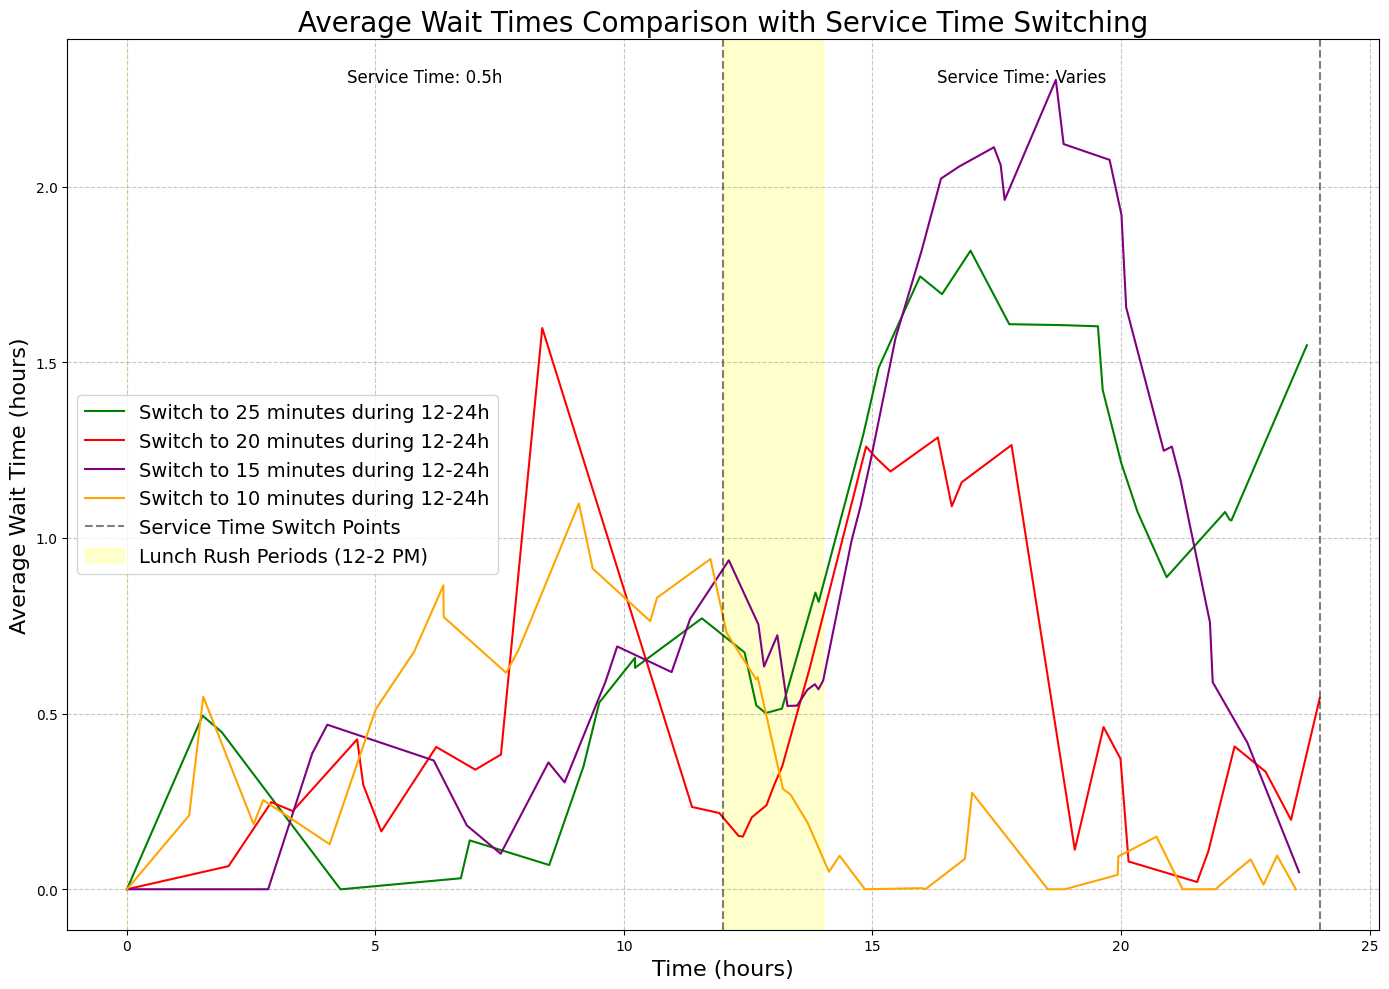

In [ ]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt

class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, base_service_time, switch_service_time, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.base_service_time = base_service_time  # Base service time (0.5 hours)
        self.switch_service_time = switch_service_time  # Service time to switch to
        self.current_service_time = base_service_time  # Start with base service time
        self.mu_rate = 1 / self.current_service_time  # Initial service rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.service_time_history = [(0, base_service_time)]  # Track service time changes
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update service time based on simulation time
    def update_service_time(self, env):
        while True:
            # Check the current hour and update service time accordingly
            if 12 <= env.now < 24:
                # Switch to the alternate service time during hours 12-24
                if self.current_service_time != self.switch_service_time:
                    self.current_service_time = self.switch_service_time
                    self.mu_rate = 1 / self.current_service_time
                    self.service_time_history.append((env.now, self.current_service_time))
            else:
                # Use base service time during hours 0-12 and 24-36
                if self.current_service_time != self.base_service_time:
                    self.current_service_time = self.base_service_time
                    self.mu_rate = 1 / self.current_service_time
                    self.service_time_history.append((env.now, self.current_service_time))

            # Check every hour
            yield env.timeout(1)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the service time update process
        env.process(self.update_service_time(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist, self.service_time_history

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run multiple service time simulations with lunch rush and switching
def run_multiple_service_time_simulations(initial_lambda_rate, base_service_time, switch_service_times, duration, num_servers):
    results = {}

    # Run simulations for each switch service time
    for switch_time in switch_service_times:
        print(f"\nRunning simulation with base service time = {base_service_time} hours, switch service time = {switch_time} hours...")

        # Run simulation with lunch rush
        sim_lunch = QueueSimulation_lunchRush(
            initial_lambda_rate,
            base_service_time,
            switch_time,
            duration,
            num_servers,
            lunch_rush=True
        )

        lunch_results = sim_lunch.run_simulation()

        # Store results
        results[switch_time] = {
            'avg_service_time': lunch_results[0],
            'avg_wait_time': lunch_results[1],
            'avg_customers': lunch_results[2],
            'avg_utilization': lunch_results[3],
            'wait_times_data': lunch_results[5],  # This contains the time series data for wait times
            'service_time_history': lunch_results[8]  # Service time change history
        }

    return results

# Function to display comparison table
def display_comparison_table(results, base_service_time, switch_service_times):
    # Prepare data for the table
    s_time = [25, 20, 15, 10]
    data = {
        'Switch Service Time (hours)': s_time,
        'Avg Service Time (hours)': [results[st]['avg_service_time'] for st in switch_service_times],
        'Avg Wait Time (hours)': [results[st]['avg_wait_time'] for st in switch_service_times],
        'Avg Customers in System': [results[st]['avg_customers'] for st in switch_service_times],
        'Avg Server Utilization': [results[st]['avg_utilization'] for st in switch_service_times]
    }

    # Print the table
    print(f"\nComparison with Base Service Time = {base_service_time} hours and Different Switch Service Times:")
    print("-" * 120)
    print(f"{'Switch Service Time (minutes)':<25} {'Avg Service Time':<25} {'Avg Wait Time':<25} {'Avg Customers':<25} {'Avg Utilization':<25}")
    print("-" * 120)

    # Print each row of the table
    for i in range(len(switch_service_times)):
        print(f"{data['Switch Service Time (hours)'][i]:<30} "
              f"{data['Avg Service Time (hours)'][i]:<25.3f} "
              f"{data['Avg Wait Time (hours)'][i]:<25.3f} "
              f"{data['Avg Customers in System'][i]:<25.3f} "
              f"{data['Avg Server Utilization'][i]:<25.3f}")

    print("-" * 120)

    return data

# Function to plot the wait times for different service times
def plot_wait_times_comparison(results, base_service_time, switch_service_times, duration):
    plt.figure(figsize=(14, 10))

    # Colors for different service times
    colors = ['green', 'red', 'purple', 'orange']
    times = ['25', '20', '15', '10']

    # Plot data for each service time
    for i, st in enumerate(switch_service_times):
        # Extract and sort time series data
        wait_data = sorted(results[st]['wait_times_data'])
        if wait_data:
            times, wait_values = zip(*wait_data)
            plt.plot(times, wait_values, label=f'Switch to {int(st * 60)} minutes during 12-24h', color=colors[i % len(colors)])

    # Add vertical lines to mark the service time switch points
    plt.axvline(x=12, color='black', linestyle='--', alpha=0.5, label='Service Time Switch Points')
    plt.axvline(x=24, color='black', linestyle='--', alpha=0.5)

    # Add text annotations for the service time periods
    plt.text(6, plt.ylim()[1] * 0.95, f'Service Time: {base_service_time}h',
             horizontalalignment='center', fontsize=12)
    plt.text(18, plt.ylim()[1] * 0.95, 'Service Time: Varies',
             horizontalalignment='center', fontsize=12)

    # Highlight lunch rush periods (they repeat every 24 hours)
    for day in range(int(duration/24) + 1):  # For each day in the simulation
        start_hour = day * 24 + 12
        end_hour = day * 24 + 14
        if start_hour < duration:
            end_hour = min(end_hour, duration)  # Make sure we don't go beyond simulation time
            plt.axvspan(start_hour, end_hour, color='yellow', alpha=0.2)

    # Add a single legend entry for lunch rush periods
    plt.axvspan(0, 0, color='yellow', alpha=0.2, label='Lunch Rush Periods (12-2 PM)')

    # Formatting
    plt.title('Average Wait Times Comparison with Service Time Switching', fontsize=20)
    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Average Wait Time (hours)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tight_layout()

    # Display the plot
    plt.show()

# Main function to run simulations with multiple service times
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    base_service_time = 0.5  # Base service time for all simulations (hours)
    switch_service_times = [5/12, 1/3, 1/4, 1/6]  # Different service times to switch to during 12-24 hours
    duration = 24  # Simulation duration in hours
    num_servers = 4  # Number of servers

    # Run simulations for different switch service times
    results = run_multiple_service_time_simulations(initial_lambda_rate, base_service_time, switch_service_times, duration, num_servers)

    # Display comparison table
    table_data = display_comparison_table(results, base_service_time, switch_service_times)

    # Plot wait times comparison
    plot_wait_times_comparison(results, base_service_time, switch_service_times, duration)


Running 1000 simulations for each configuration...
Running simulation 1/1000...
Running simulation 11/1000...
Running simulation 21/1000...
Running simulation 31/1000...
Running simulation 41/1000...
Running simulation 51/1000...
Running simulation 61/1000...
Running simulation 71/1000...
Running simulation 81/1000...
Running simulation 91/1000...
Running simulation 101/1000...
Running simulation 111/1000...
Running simulation 121/1000...
Running simulation 131/1000...
Running simulation 141/1000...
Running simulation 151/1000...
Running simulation 161/1000...
Running simulation 171/1000...
Running simulation 181/1000...
Running simulation 191/1000...
Running simulation 201/1000...
Running simulation 211/1000...
Running simulation 221/1000...
Running simulation 231/1000...
Running simulation 241/1000...
Running simulation 251/1000...
Running simulation 261/1000...
Running simulation 271/1000...
Running simulation 281/1000...
Running simulation 291/1000...
Running simulation 301/1000...

<ipython-input-23-edd458a38abb>:342: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),


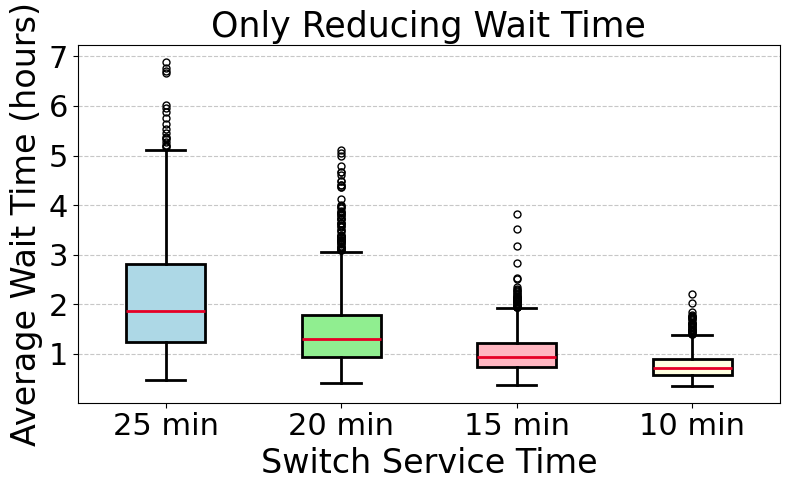

In [ ]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt
from scipy import stats

class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, base_service_time, switch_service_time, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.base_service_time = base_service_time  # Base service time (0.5 hours)
        self.switch_service_time = switch_service_time  # Service time to switch to
        self.current_service_time = base_service_time  # Start with base service time
        self.mu_rate = 1 / self.current_service_time  # Initial service rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.service_time_history = [(0, base_service_time)]  # Track service time changes
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update service time based on simulation time
    def update_service_time(self, env):
        while True:
            # Check the current hour and update service time accordingly
            if 12 <= env.now < 24:
                # Switch to the alternate service time during hours 12-24
                if self.current_service_time != self.switch_service_time:
                    self.current_service_time = self.switch_service_time
                    self.mu_rate = 1 / self.current_service_time
                    self.service_time_history.append((env.now, self.current_service_time))
            else:
                # Use base service time during hours 0-12 and 24-36
                if self.current_service_time != self.base_service_time:
                    self.current_service_time = self.base_service_time
                    self.mu_rate = 1 / self.current_service_time
                    self.service_time_history.append((env.now, self.current_service_time))

            # Check every hour
            yield env.timeout(1)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the service time update process
        env.process(self.update_service_time(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist, self.service_time_history

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run multiple service time simulations with lunch rush and switching
def run_multiple_service_time_simulations(initial_lambda_rate, base_service_time, switch_service_times, duration, num_servers, num_runs=1):
    # Create dictionaries to store results across multiple runs
    all_runs_results = {st: {
        'avg_service_time': [],
        'avg_wait_time': [],
        'avg_customers': [],
        'avg_utilization': []
    } for st in switch_service_times}

    # Run simulations for each switch service time
    for run in range(num_runs):
        if run % 10 == 0:  # Print progress every 10 runs
            print(f"Running simulation {run+1}/{num_runs}...")

        for switch_time in switch_service_times:
            # Run simulation with lunch rush
            sim_lunch = QueueSimulation_lunchRush(
                initial_lambda_rate,
                base_service_time,
                switch_time,
                duration,
                num_servers,
                lunch_rush=True
            )

            lunch_results = sim_lunch.run_simulation()

            # Store results for this run
            all_runs_results[switch_time]['avg_service_time'].append(lunch_results[0])
            all_runs_results[switch_time]['avg_wait_time'].append(lunch_results[1])
            all_runs_results[switch_time]['avg_customers'].append(lunch_results[2])
            all_runs_results[switch_time]['avg_utilization'].append(lunch_results[3])

    # Calculate average results and confidence intervals across all runs
    final_results = {}
    for st in switch_service_times:
        final_results[st] = {
            'avg_service_time': np.mean(all_runs_results[st]['avg_service_time']),
            'service_time_ci': calculate_confidence_interval(all_runs_results[st]['avg_service_time']),
            'avg_wait_time': np.mean(all_runs_results[st]['avg_wait_time']),
            'wait_time_ci': calculate_confidence_interval(all_runs_results[st]['avg_wait_time']),
            'avg_customers': np.mean(all_runs_results[st]['avg_customers']),
            'customers_ci': calculate_confidence_interval(all_runs_results[st]['avg_customers']),
            'avg_utilization': np.mean(all_runs_results[st]['avg_utilization']),
            'utilization_ci': calculate_confidence_interval(all_runs_results[st]['avg_utilization']),
            'all_wait_times': all_runs_results[st]['avg_wait_time']  # Store all runs for plotting
        }

    return final_results

# Function to calculate 95% confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    if not data:
        return (0, 0)

    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)

    return (mean - h, mean + h)

# Function to display comparison table with confidence intervals
def display_comparison_table_with_ci(results, base_service_time, switch_service_times):
    # Prepare data for the table
    s_time_minutes = [int(st * 60) for st in switch_service_times]
    data = {
        'Switch Service Time (minutes)': s_time_minutes,
        'Avg Service Time (hours)': [results[st]['avg_service_time'] for st in switch_service_times],
        'Service Time CI': [results[st]['service_time_ci'] for st in switch_service_times],
        'Avg Wait Time (hours)': [results[st]['avg_wait_time'] for st in switch_service_times],
        'Wait Time CI': [results[st]['wait_time_ci'] for st in switch_service_times],
        'Avg Customers in System': [results[st]['avg_customers'] for st in switch_service_times],
        'Customers CI': [results[st]['customers_ci'] for st in switch_service_times],
        'Avg Server Utilization': [results[st]['avg_utilization'] for st in switch_service_times],
        'Utilization CI': [results[st]['utilization_ci'] for st in switch_service_times]
    }

    # Print the table
    print(f"\nComparison with Base Service Time = {base_service_time} hours and Different Switch Service Times (Averaged over 100 runs):")
    print("-" * 140)
    print(f"{'Switch Service Time':<20} {'Avg Service Time':<25} {'Avg Wait Time':<25} {'Avg Customers':<25} {'Avg Utilization':<25}")
    print(f"{'(minutes)':<20} {'(hours) [95% CI]':<25} {'(hours) [95% CI]':<25} {'in System [95% CI]':<25} {'[95% CI]':<25}")
    print("-" * 140)

    # Print each row of the table
    for i in range(len(switch_service_times)):
        service_ci = data['Service Time CI'][i]
        wait_ci = data['Wait Time CI'][i]
        customers_ci = data['Customers CI'][i]
        util_ci = data['Utilization CI'][i]

        print(f"{data['Switch Service Time (minutes)'][i]:<20} "
              f"{data['Avg Service Time (hours)'][i]:.3f} [{service_ci[0]:.3f}, {service_ci[1]:.3f}] "
              f"{data['Avg Wait Time (hours)'][i]:.3f} [{wait_ci[0]:.3f}, {wait_ci[1]:.3f}] "
              f"{data['Avg Customers in System'][i]:.3f} [{customers_ci[0]:.3f}, {customers_ci[1]:.3f}] "
              f"{data['Avg Server Utilization'][i]:.3f} [{util_ci[0]:.3f}, {util_ci[1]:.3f}]")

    print("-" * 140)

    return data

# Function to plot boxplots of wait times
def plot_wait_time_boxplots(results, base_service_time, switch_service_times):
    plt.figure(figsize=(8, 5))

    # Prepare data for boxplot
    data = [results[st]['all_wait_times'] for st in switch_service_times]
    labels = [f'{int(st * 60)} min' for st in switch_service_times]

    # Create boxplot
    box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),
                      whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2),
                      medianprops=dict(linewidth=2, color='#E60026'), flierprops=dict(marker='o', markersize=5))

    # Customize boxplot colors
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Add labels and formatting
    plt.title(f'Only Reducing Wait Time', fontsize=25)
    plt.xlabel('Switch Service Time', fontsize=24)
    plt.ylabel('Average Wait Time (hours)', fontsize=24)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

# Main function to run simulations with multiple service times
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    base_service_time = 0.5  # Base service time for all simulations (hours)
    switch_service_times = [5/12, 1/3, 1/4, 1/6]  # Different service times to switch to during 12-24 hours (hours)
    duration = 36  # Simulation duration in hours
    num_servers = 4  # Number of servers
    num_runs = 1000  # Number of simulation runs for each configuration

    print(f"Running {num_runs} simulations for each configuration...")

    # Run simulations for different switch service times
    results = run_multiple_service_time_simulations(
        initial_lambda_rate,
        base_service_time,
        switch_service_times,
        duration,
        num_servers,
        num_runs
    )

    # Display comparison table with confidence intervals
    table_data = display_comparison_table_with_ci(results, base_service_time, switch_service_times)

    # Plot boxplots of wait times
    plot_wait_time_boxplots(results, base_service_time, switch_service_times)

Running 1000 simulations for each server configuration...
Running simulation 1/1000...
Running simulation 11/1000...
Running simulation 21/1000...
Running simulation 31/1000...
Running simulation 41/1000...
Running simulation 51/1000...
Running simulation 61/1000...
Running simulation 71/1000...
Running simulation 81/1000...
Running simulation 91/1000...
Running simulation 101/1000...
Running simulation 111/1000...
Running simulation 121/1000...
Running simulation 131/1000...
Running simulation 141/1000...
Running simulation 151/1000...
Running simulation 161/1000...
Running simulation 171/1000...
Running simulation 181/1000...
Running simulation 191/1000...
Running simulation 201/1000...
Running simulation 211/1000...
Running simulation 221/1000...
Running simulation 231/1000...
Running simulation 241/1000...
Running simulation 251/1000...
Running simulation 261/1000...
Running simulation 271/1000...
Running simulation 281/1000...
Running simulation 291/1000...
Running simulation 301/

<ipython-input-24-ba0ea8427c72>:300: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),


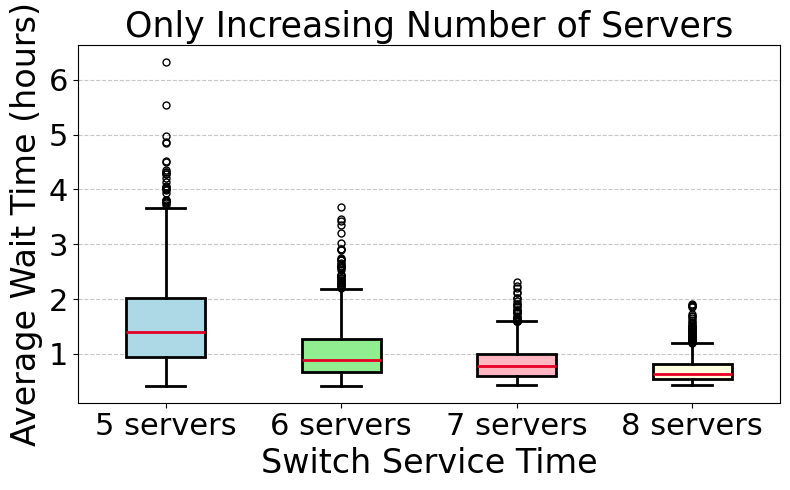

In [ ]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt
from scipy import stats

class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, service_time, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.service_time = service_time  # Service time (0.5 hours)
        self.current_service_time = service_time  # Start with base service time
        self.mu_rate = 1 / self.current_service_time  # Initial service rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run simulations with varying numbers of servers
def run_multiple_server_simulations(initial_lambda_rate, service_time, duration, server_counts, num_runs=1):
    # Create dictionaries to store results across multiple runs
    all_runs_results = {servers: {
        'avg_service_time': [],
        'avg_wait_time': [],
        'avg_customers': [],
        'avg_utilization': []
    } for servers in server_counts}

    # Run simulations for each server count
    for run in range(num_runs):
        if run % 10 == 0:  # Print progress every 10 runs
            print(f"Running simulation {run+1}/{num_runs}...")

        for num_servers in server_counts:
            # Run simulation with lunch rush
            sim = QueueSimulation_lunchRush(
                initial_lambda_rate,
                service_time,
                duration,
                num_servers,
                lunch_rush=True
            )

            results = sim.run_simulation()

            # Store results for this run
            all_runs_results[num_servers]['avg_service_time'].append(results[0])
            all_runs_results[num_servers]['avg_wait_time'].append(results[1])
            all_runs_results[num_servers]['avg_customers'].append(results[2])
            all_runs_results[num_servers]['avg_utilization'].append(results[3])

    # Calculate average results and confidence intervals across all runs
    final_results = {}
    for servers in server_counts:
        final_results[servers] = {
            'avg_service_time': np.mean(all_runs_results[servers]['avg_service_time']),
            'service_time_ci': calculate_confidence_interval(all_runs_results[servers]['avg_service_time']),
            'avg_wait_time': np.mean(all_runs_results[servers]['avg_wait_time']),
            'wait_time_ci': calculate_confidence_interval(all_runs_results[servers]['avg_wait_time']),
            'avg_customers': np.mean(all_runs_results[servers]['avg_customers']),
            'customers_ci': calculate_confidence_interval(all_runs_results[servers]['avg_customers']),
            'avg_utilization': np.mean(all_runs_results[servers]['avg_utilization']),
            'utilization_ci': calculate_confidence_interval(all_runs_results[servers]['avg_utilization']),
            'all_wait_times': all_runs_results[servers]['avg_wait_time']  # Store all runs for plotting
        }

    return final_results

# Function to calculate 95% confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    if not data:
        return (0, 0)

    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)

    return (mean - h, mean + h)

# Function to display comparison table with confidence intervals
def display_comparison_table_with_ci(results, service_time, server_counts):
    # Print the table
    print(f"\nComparison with Service Time = {service_time} hours and Different Server Counts (Averaged over 100 runs):")
    print("-" * 140)
    print(f"{'Number of':<20} {'Avg Service Time':<25} {'Avg Wait Time':<25} {'Avg Customers':<25} {'Avg Utilization':<25}")
    print(f"{'Servers':<20} {'(hours) [95% CI]':<25} {'(hours) [95% CI]':<25} {'in System [95% CI]':<25} {'[95% CI]':<25}")
    print("-" * 140)

    # Print each row of the table
    for servers in server_counts:
        service_ci = results[servers]['service_time_ci']
        wait_ci = results[servers]['wait_time_ci']
        customers_ci = results[servers]['customers_ci']
        util_ci = results[servers]['utilization_ci']

        print(f"{servers:<20} "
              f"{results[servers]['avg_service_time']:.3f} [{service_ci[0]:.3f}, {service_ci[1]:.3f}] "
              f"{results[servers]['avg_wait_time']:.3f} [{wait_ci[0]:.3f}, {wait_ci[1]:.3f}] "
              f"{results[servers]['avg_customers']:.3f} [{customers_ci[0]:.3f}, {customers_ci[1]:.3f}] "
              f"{results[servers]['avg_utilization']:.3f} [{util_ci[0]:.3f}, {util_ci[1]:.3f}]")

    print("-" * 140)

# Function to plot boxplots of wait times
def plot_wait_time_boxplots(results, service_time, server_counts):
    plt.figure(figsize=(8, 5))

    # Prepare data for boxplot
    data = [results[servers]['all_wait_times'] for servers in server_counts]
    labels = [f'{servers} servers' for servers in server_counts]

    # Create boxplot
    box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),
                      whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2),
                      medianprops=dict(linewidth=2, color='#E60026'), flierprops=dict(marker='o', markersize=5))

    # Customize boxplot colors
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Add labels and formatting
    plt.title(f'Only Increasing Number of Servers', fontsize=25)
    plt.xlabel('Switch Service Time', fontsize=24)
    plt.ylabel('Average Wait Time (hours)', fontsize=24)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

# Main function to run simulations with varying server counts
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    service_time = 0.5  # Constant service time for all simulations (hours)
    duration = 36  # Simulation duration in hours
    server_counts = [5, 6, 7, 8]  # Different numbers of servers to test
    num_runs = 1000  # Number of simulation runs for each configuration

    print(f"Running {num_runs} simulations for each server configuration...")

    # Run simulations for different server counts
    results = run_multiple_server_simulations(
        initial_lambda_rate,
        service_time,
        duration,
        server_counts,
        num_runs
    )

    # Display comparison table with confidence intervals
    display_comparison_table_with_ci(results, service_time, server_counts)

    # Plot boxplots of wait times
    plot_wait_time_boxplots(results, service_time, server_counts)


Running 1000 simulations for each server configuration...
Running simulation 1/1000...
Running simulation 11/1000...
Running simulation 21/1000...
Running simulation 31/1000...
Running simulation 41/1000...
Running simulation 51/1000...
Running simulation 61/1000...
Running simulation 71/1000...
Running simulation 81/1000...
Running simulation 91/1000...
Running simulation 101/1000...
Running simulation 111/1000...
Running simulation 121/1000...
Running simulation 131/1000...
Running simulation 141/1000...
Running simulation 151/1000...
Running simulation 161/1000...
Running simulation 171/1000...
Running simulation 181/1000...
Running simulation 191/1000...
Running simulation 201/1000...
Running simulation 211/1000...
Running simulation 221/1000...
Running simulation 231/1000...
Running simulation 241/1000...
Running simulation 251/1000...
Running simulation 261/1000...
Running simulation 271/1000...
Running simulation 281/1000...
Running simulation 291/1000...
Running simulation 301/

<ipython-input-26-9c533b777511>:294: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),


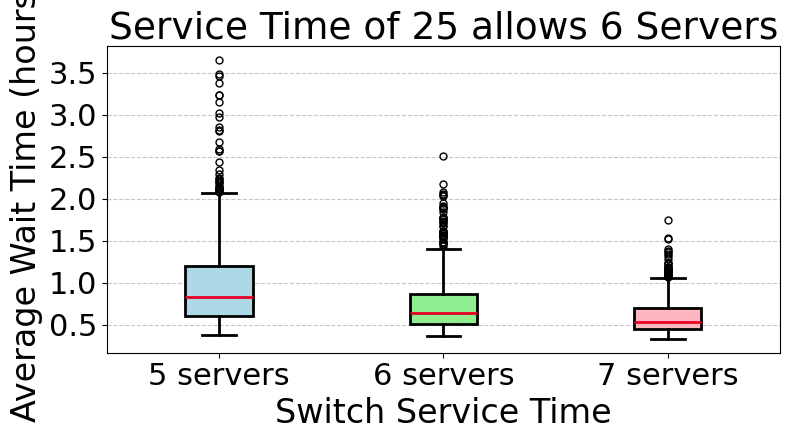

Running simulation 1/1000...
Running simulation 11/1000...
Running simulation 21/1000...
Running simulation 31/1000...
Running simulation 41/1000...
Running simulation 51/1000...
Running simulation 61/1000...
Running simulation 71/1000...
Running simulation 81/1000...
Running simulation 91/1000...
Running simulation 101/1000...
Running simulation 111/1000...
Running simulation 121/1000...
Running simulation 131/1000...
Running simulation 141/1000...
Running simulation 151/1000...
Running simulation 161/1000...
Running simulation 171/1000...
Running simulation 181/1000...
Running simulation 191/1000...
Running simulation 201/1000...
Running simulation 211/1000...
Running simulation 221/1000...
Running simulation 231/1000...
Running simulation 241/1000...
Running simulation 251/1000...
Running simulation 261/1000...
Running simulation 271/1000...
Running simulation 281/1000...
Running simulation 291/1000...
Running simulation 301/1000...
Running simulation 311/1000...
Running simulation 

<ipython-input-26-9c533b777511>:294: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),


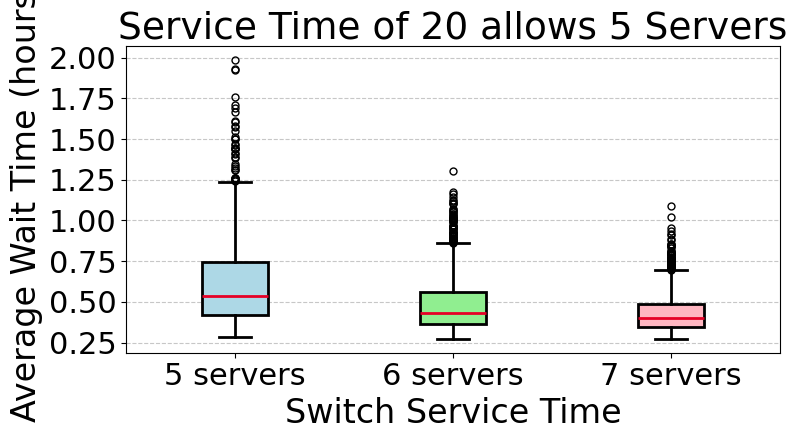

In [ ]:
class QueueSimulation_lunchRush:
    def __init__(self, initial_lambda_rate, service_time, duration, num_servers, lunch_rush=False):
        # Initialize the simulation parameters
        self.lambda_rate = initial_lambda_rate
        self.base_lambda_rate = initial_lambda_rate
        self.service_time = service_time  # Service time (0.5 hours)
        self.current_service_time = service_time  # Start with base service time
        self.mu_rate = 1 / self.current_service_time  # Initial service rate
        self.duration = duration
        self.num_servers = num_servers  # number of servers
        self.lambda_history = [(0, initial_lambda_rate)]  # Track lambda changes over time
        self.lunch_rush = lunch_rush  # Whether to simulate lunch rush

    # Method to generate inter-arrival times using an exponential distribution
    def generate_interarrival(self):
        return np.random.exponential(1. / self.lambda_rate)

    # Method to generate service times using an exponential distribution
    def generate_service(self):
        return np.random.exponential(1. / self.mu_rate)

    # Method to update lambda rate hourly and handle lunch rush if enabled
    def update_lambda(self, env):
        # Initial lambda rate setup based on current time (including lunch rush if applicable)
        hour = env.now % 24
        if self.lunch_rush and 12 <= hour < 14:
            self.lambda_rate = self.base_lambda_rate * 4
        else:
            self.lambda_rate = self.base_lambda_rate

        self.lambda_history = [(0, self.lambda_rate)]

        # Schedule the next hourly update
        next_hour = int(env.now) + 1

        while True:
            # Wait until the next hour
            time_to_next_hour = next_hour - env.now
            yield env.timeout(time_to_next_hour)

            # Update the hour
            hour = next_hour % 24

            # Get a new random base lambda rate for the next hour
            self.base_lambda_rate = random.randint(2, 12)

            # Apply lunch rush multiplier if applicable
            if self.lunch_rush and 12 <= hour < 14:
                self.lambda_rate = self.base_lambda_rate * 4
            else:
                self.lambda_rate = self.base_lambda_rate

            # Record the lambda change
            self.lambda_history.append((env.now, self.lambda_rate))

            # Set up for the next hour
            next_hour += 1

    # Simulation method that controls the arrival of customers and processing them
    def Simulation(self, env, servers):
        self.num_customers = 0
        self.total_busy_time = 0  # Track total time servers busy
        while True:
            interarrival_time = self.generate_interarrival()
            yield env.timeout(interarrival_time)  # Yield until the next arrival
            self.num_customers += 1
            env.process(self.Customer(env, self.num_customers, servers))  # Start a new customer process

    # Method to model the behavior of a customer
    def Customer(self, env, customer, servers):
        with servers.request() as request:
            t_arrival = env.now
            # Track the number of customers currently in the system
            self.in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))

            # Add this customer to active customers
            self.active_customers.append(t_arrival)

            # Calculate snapshot of wait time metrics (less frequently than before)
            # Only calculate for certain events to reduce computational load
            if customer % 10 == 0:  # Sample every 10th customer
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_arrival, current_total_wait))
                self.avg_wait_times_over_time.append((t_arrival, current_avg_wait))

            # Yield until the customer gets service (waiting for a server)
            yield request

            # Generate service time and wait for service to complete
            service_time = self.generate_service()
            t_service = env.now
            yield env.timeout(service_time)

            # Customer departs after service
            t_depart = env.now
            self.total_busy_time += service_time  # Update time servers were busy

            # Track the number of customers in the system after this customer departs
            self.in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))

            # Remove this customer from active customers
            self.active_customers.remove(t_arrival)

            # Calculate wait time metrics on departure (also less frequently)
            if customer % 10 == 0:
                if self.active_customers:
                    current_total_wait = sum(env.now - arrival_time for arrival_time in self.active_customers)
                    current_avg_wait = current_total_wait / len(self.active_customers)
                else:
                    current_total_wait = 0
                    current_avg_wait = 0

                self.wait_times_over_time.append((t_depart, current_total_wait))
                self.avg_wait_times_over_time.append((t_depart, current_avg_wait))

            # Only update utilization occasionally to reduce computational load
            if customer % 20 == 0:
                self.utilisation_log.append((t_depart, self.total_busy_time / (self.num_servers * t_depart) if t_depart > 0 else 0))

            # Record wait time and service time for the customer
            wait_time = t_depart - t_arrival
            self.waits.append(wait_time)
            self.service_t.append(service_time)
            # Only log details for every 20th customer to reduce memory usage
            if customer % 20 == 0:
                self.log.append((customer, t_arrival, t_service, t_depart))

    # Method to run the simulation
    def run_simulation(self):
        # Initialize result storage
        self.waits = []
        self.service_t = []
        self.num_customers = 0
        self.in_systems = [(0, 0)]
        self.utilisation_log = [(0, 0)]
        self.log = []
        self.active_customers = []
        self.wait_times_over_time = [(0, 0)]
        self.avg_wait_times_over_time = [(0, 0)]

        # Create the simulation environment and server
        env = simpy.Environment()
        servers = simpy.Resource(env, capacity=self.num_servers)

        # Start the lambda update process
        env.process(self.update_lambda(env))

        # Start the simulation
        env.process(self.Simulation(env, servers))

        # Run the simulation for a given time
        env.run(until=self.duration)

        # Calculate the average customer service and waiting times
        average_service_time = np.mean(self.service_t) if self.service_t else 0
        average_wait_time = np.mean(self.waits) if self.waits else 0

        # Calculate average utilisation of servers
        total_available_time = self.num_servers * self.duration
        average_utilisation = self.total_busy_time / total_available_time if total_available_time > 0 else 0

        # Calculate average number of customers
        auc, last_t, last_l = 0, 0, 0
        for t, l in self.in_systems:
            auc += (t - last_t) * last_l
            last_t, last_l = t, l
        average_number_customer = auc / last_t if last_t > 0 else 0

        # Calculate wait time distribution
        wait_time_bins = [0, 5/60, 0.5, 1, 2, 5, 10, float('inf')]  # in hours
        wait_time_dist = self.get_wait_time_distribution(wait_time_bins)

        return average_service_time, average_wait_time, average_number_customer, average_utilisation, self.wait_times_over_time, self.avg_wait_times_over_time, self.lambda_history, wait_time_dist

    # Method to calculate wait time distribution
    def get_wait_time_distribution(self, bins):
        counts = [0] * (len(bins) - 1)
        total = len(self.waits)

        if total == 0:
            return [0] * (len(bins) - 1)

        for wait in self.waits:
            for i in range(len(bins) - 1):
                if bins[i] <= wait < bins[i+1]:
                    counts[i] += 1
                    break

        # Convert to percentages
        percentages = [count / total * 100 for count in counts]
        return percentages

# Function to run simulations with varying numbers of servers
def run_multiple_server_simulations(initial_lambda_rate, service_time, duration, server_counts, num_runs=1):
    # Create dictionaries to store results across multiple runs
    all_runs_results = {servers: {
        'avg_service_time': [],
        'avg_wait_time': [],
        'avg_customers': [],
        'avg_utilization': []
    } for servers in server_counts}

    # Run simulations for each server count
    for run in range(num_runs):
        if run % 10 == 0:  # Print progress every 10 runs
            print(f"Running simulation {run+1}/{num_runs}...")

        for num_servers in server_counts:
            # Run simulation with lunch rush
            sim = QueueSimulation_lunchRush(
                initial_lambda_rate,
                service_time,
                duration,
                num_servers,
                lunch_rush=True
            )

            results = sim.run_simulation()

            # Store results for this run
            all_runs_results[num_servers]['avg_service_time'].append(results[0])
            all_runs_results[num_servers]['avg_wait_time'].append(results[1])
            all_runs_results[num_servers]['avg_customers'].append(results[2])
            all_runs_results[num_servers]['avg_utilization'].append(results[3])

    # Calculate average results and confidence intervals across all runs
    final_results = {}
    for servers in server_counts:
        final_results[servers] = {
            'avg_service_time': np.mean(all_runs_results[servers]['avg_service_time']),
            'service_time_ci': calculate_confidence_interval(all_runs_results[servers]['avg_service_time']),
            'avg_wait_time': np.mean(all_runs_results[servers]['avg_wait_time']),
            'wait_time_ci': calculate_confidence_interval(all_runs_results[servers]['avg_wait_time']),
            'avg_customers': np.mean(all_runs_results[servers]['avg_customers']),
            'customers_ci': calculate_confidence_interval(all_runs_results[servers]['avg_customers']),
            'avg_utilization': np.mean(all_runs_results[servers]['avg_utilization']),
            'utilization_ci': calculate_confidence_interval(all_runs_results[servers]['avg_utilization']),
            'all_wait_times': all_runs_results[servers]['avg_wait_time']  # Store all runs for plotting
        }

    return final_results

# Function to calculate 95% confidence interval
def calculate_confidence_interval(data, confidence=0.95):
    if not data:
        return (0, 0)

    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n - 1)

    return (mean - h, mean + h)

# Function to display comparison table with confidence intervals
def display_comparison_table_with_ci(results, service_time, server_counts):
    # Print the table
    print(f"\nComparison with Service Time = {service_time} hours and Different Server Counts (Averaged over 100 runs):")
    print("-" * 140)
    print(f"{'Number of':<20} {'Avg Service Time':<25} {'Avg Wait Time':<25} {'Avg Customers':<25} {'Avg Utilization':<25}")
    print(f"{'Servers':<20} {'(hours) [95% CI]':<25} {'(hours) [95% CI]':<25} {'in System [95% CI]':<25} {'[95% CI]':<25}")
    print("-" * 140)

    # Print each row of the table
    for servers in server_counts:
        service_ci = results[servers]['service_time_ci']
        wait_ci = results[servers]['wait_time_ci']
        customers_ci = results[servers]['customers_ci']
        util_ci = results[servers]['utilization_ci']

        print(f"{servers:<20} "
              f"{results[servers]['avg_service_time']:.3f} [{service_ci[0]:.3f}, {service_ci[1]:.3f}] "
              f"{results[servers]['avg_wait_time']:.3f} [{wait_ci[0]:.3f}, {wait_ci[1]:.3f}] "
              f"{results[servers]['avg_customers']:.3f} [{customers_ci[0]:.3f}, {customers_ci[1]:.3f}] "
              f"{results[servers]['avg_utilization']:.3f} [{util_ci[0]:.3f}, {util_ci[1]:.3f}]")

    print("-" * 140)

# Function to plot boxplots of wait times
def plot_wait_time_boxplots(results, service_time, server_counts, server_amount):
    plt.figure(figsize=(8, 4.5))

    # Prepare data for boxplot
    data = [results[servers]['all_wait_times'] for servers in server_counts]
    labels = [f'{servers} servers' for servers in server_counts]

    # Create boxplot
    box = plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(linewidth=2),
                      whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2),
                      medianprops=dict(linewidth=2, color='#E60026'), flierprops=dict(marker='o', markersize=5))

    # Customize boxplot colors
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Add labels and formatting
    plt.title(f'Service Time of {int(service_time * 60)} allows {server_amount} Servers', fontsize=27)
    plt.xlabel('Switch Service Time', fontsize=24)
    plt.ylabel('Average Wait Time (hours)', fontsize=24)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

# Main function to run simulations with varying server counts
if __name__ == "__main__":
    # Parameters
    initial_lambda_rate = 6  # Initial arrival rate (customers per hour)
    service_time = 5/12  # Constant service time for all simulations (hours)
    duration = 36  # Simulation duration in hours
    server_counts = [5, 6, 7]  # Different numbers of servers to test
    num_runs = 1000  # Number of simulation runs for each configuration

    print(f"Running {num_runs} simulations for each server configuration...")

    # Run simulations for different server counts
    results = run_multiple_server_simulations(
        initial_lambda_rate,
        service_time,
        duration,
        server_counts,
        num_runs
    )

    # Display comparison table with confidence intervals
    display_comparison_table_with_ci(results, service_time, server_counts)

    server_amount = 6
    # Plot boxplots of wait times
    plot_wait_time_boxplots(results, service_time, server_counts, server_amount)

    service_time = 1/3
    server_amount = 5

    # Run simulations for different server counts
    results = run_multiple_server_simulations(
        initial_lambda_rate,
        service_time,
        duration,
        server_counts,
        num_runs
    )

    # Display comparison table with confidence intervals
    display_comparison_table_with_ci(results, service_time, server_counts)

    # Plot boxplots of wait times
    plot_wait_time_boxplots(results, service_time, server_counts, server_amount)
